## Create your AWS account
You can just search for "aws create account" in your browser.
Here's a quicker link: https://aws.amazon.com/resources/create-account/

After creating your account, redirect to Amazon Sagemaker(you can type in the search bar to locate faster), and click on "Studio" on the left side bar.

## Create the endpoint

Follow the instruction in the link: https://aws.amazon.com/blogs/machine-learning/llama-2-foundation-models-from-meta-are-now-available-in-amazon-sagemaker-jumpstart/, and deploy the chosen model.

Notice the endpoint may require you to run on particular instances, for Llama-2-7b-chat, you will likely to receive the following message:

" We encountered an error while preparing to deploy your endpoint. You can get more details below.

An error occurred (ResourceLimitExceeded) when calling the CreateEndpoint operation: The account-level service limit 'ml.g5.2xlarge for endpoint usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please use AWS Service Quotas to request an increase for this quota. If AWS Service Quotas is not available, contact AWS support to request an increase for this quota."

### Request instance

In order to use a compute enhanced notebook instance, you must submit a request for a service limit increase to the AWS Support Center.

1. Open the AWS Support Center console.

2. On the AWS Support Center page, choose Create Case and then choose Looking for service limit increases?.
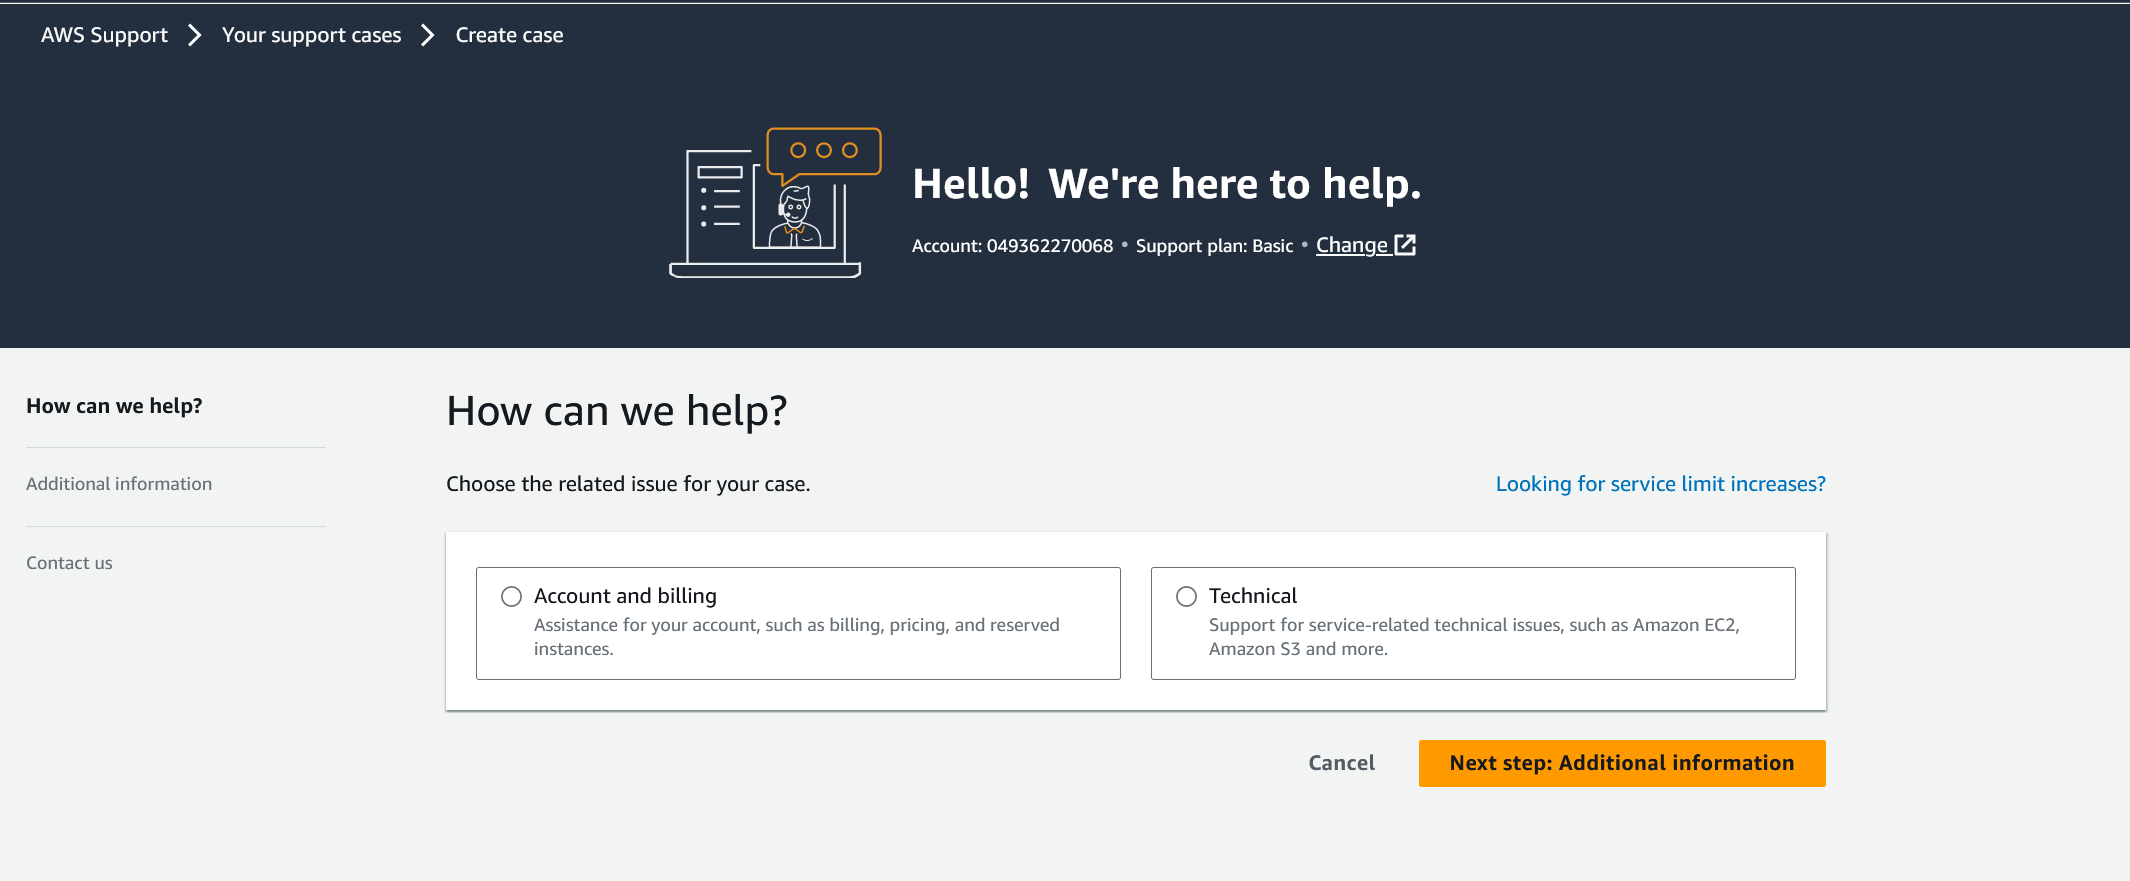

3. In the Limit type panel, search for SageMaker Notebook Instances.

4. In the Request panel, choose the Region that you are working in(US East (Northern Virginia)). For Resource Type, choose SageMaker Notebook.

5. For Limit choose ml.g5.2xlarge instances.

6. For New Limit Value, verify that the value is 1.
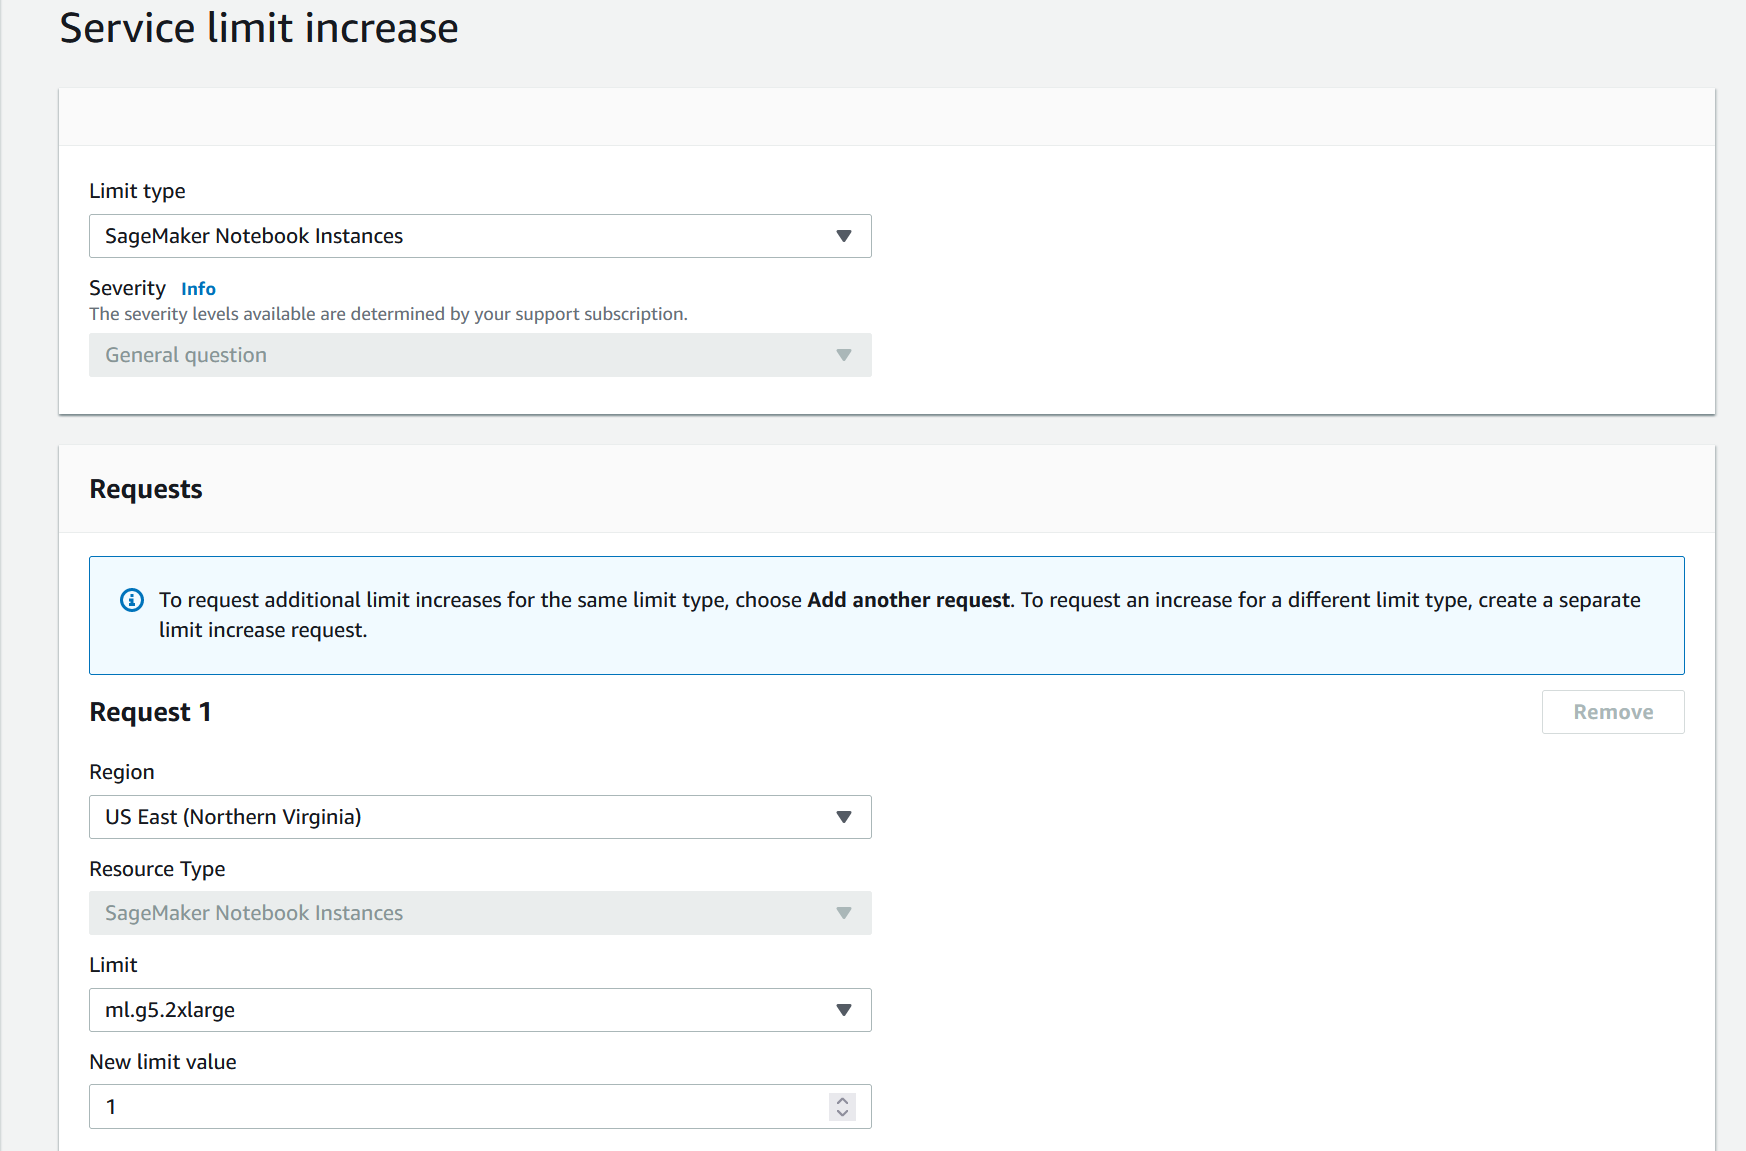

7. In Case description, provide a brief explanation of why you need the Service limit increase. For example, I need to use this to deploy Llama-2-7b-chat.

8. In Contact options, provide some details about how you would like to be contacted by the AWS service support team on the status of your Service limit increase request.

9. Choose submit.


PS: I followed the instruction in th link: https://docs.aws.amazon.com/deepcomposer/latest/devguide/deepcomposer-service-limit.html amd submitted case. I was later contacted by Amazon saying I "submitted for the wrong resource type. The error you provided mentions the CreateEndpoint operation, but the request was submitted for Notebook Instance resources (CreateNotebookInstance operation)." Of course through communication, they assigned me the quota. I did not attempt with submitting "CreateEndpoint" operation as the resource type, but anyone is encouraged to try this.

As long as you deploy the model in Sagemaker Studio, which will take a while, you should be able to open a notebook like the one below, beginning from section "Run inference on the Llama 2 endpoint you have created." to "Query endpoint that you have created", including all major contents, along with some of our edits.

### Something to note
The script expects that you have created a SageMaker endpoint named "jumpstart-dft-meta-textgeneration-llama-2-7b-f"(or any name you have on your end) and that you have appropriate access rights to access the S3 bucket and perform actions on the SageMaker endpoint. Keep in mind that this script uses a specific Llama 2 model with predefined parameters. If you want to use a different model or set different parameters, you can modify the payload dictionary within the loop.

## Run inference on the Llama 2 endpoint you have created.

In [2]:
import json
import boto3

### Supported Parameters

***
This model supports the following inference payload parameters:

* **max_new_tokens:** Model generates text until the output length (excluding the input context length) reaches max_new_tokens. If specified, it must be a positive integer.
* **temperature:** Controls the randomness in the output. Higher temperature results in output sequence with low-probability words and lower temperature results in output sequence with high-probability words. If `temperature` -> 0, it results in greedy decoding. If specified, it must be a positive float.
* **top_p:** In each step of text generation, sample from the smallest possible set of words with cumulative probability `top_p`. If specified, it must be a float between 0 and 1.

You may specify any subset of the parameters mentioned above while invoking an endpoint. 

**NOTE**: If `max_new_tokens` is not defined, the model may generate up to the maximum total tokens allowed, which is 4K for these models. This may result in endpoint query timeout errors, so it is recommended to set `max_new_tokens` when possible. For 7B, 13B, and 70B models, we recommend to set `max_new_tokens` no greater than 1500, 1000, and 500 respectively, while keeping the total number of tokens less than 4K.

**NOTE**: In order to support a 4k context length, this model has restricted query payloads to only utilize a batch size of 1. Payloads with larger batch sizes will receive an endpoint error prior to inference.

**NOTE**: This model only supports 'system', 'user' and 'assistant' roles, starting with 'system', then 'user' and alternating (u/a/u/a/u...).

***

If you wish to read files or data, you will need to create a bucket in S3:
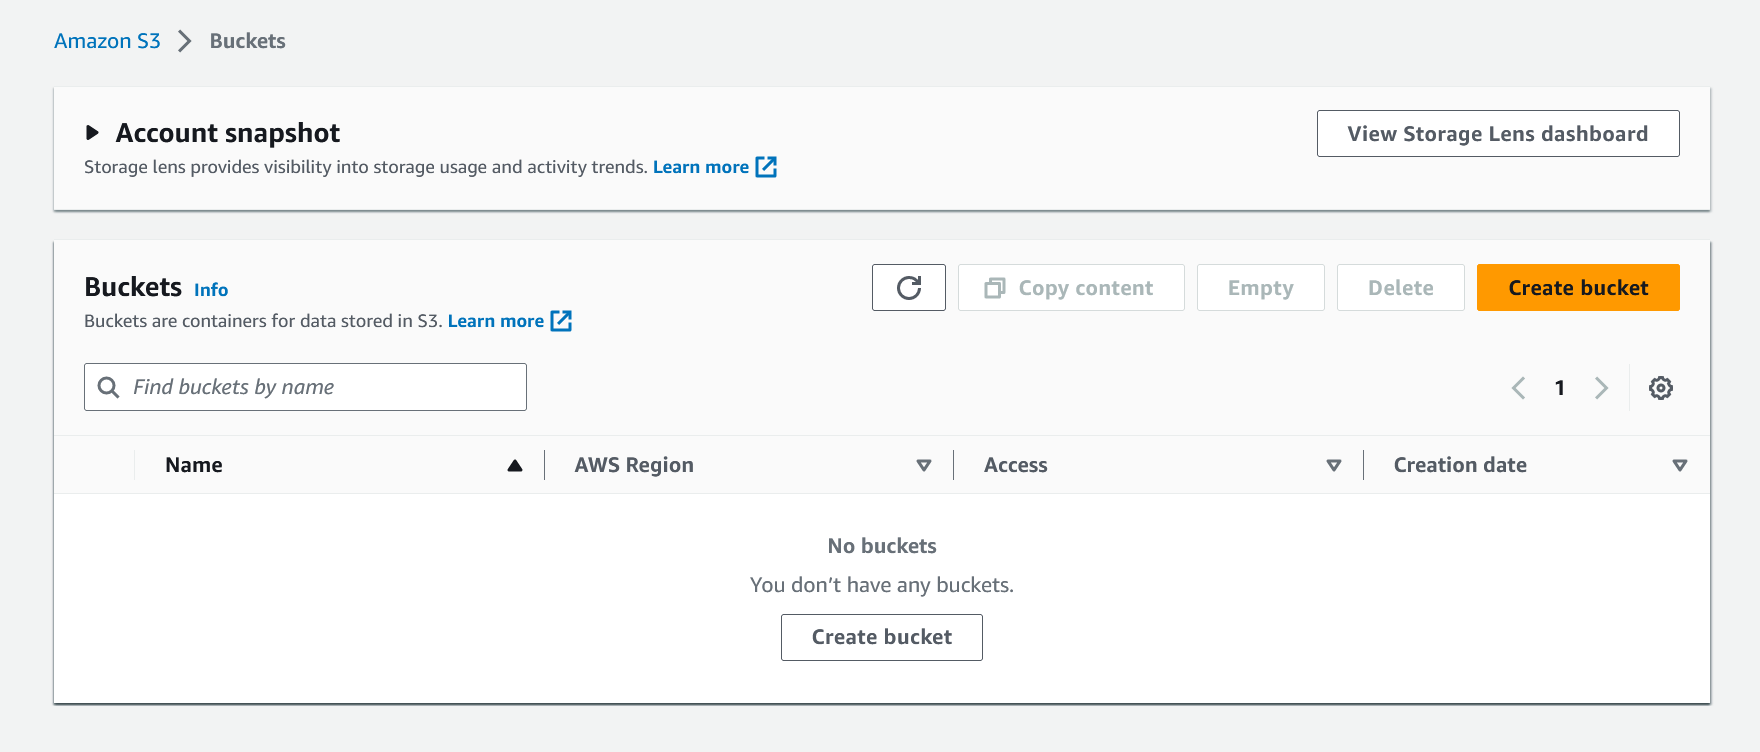
After creating a bucket, you can upload desired files and datasets.

In [3]:
from sagemaker import get_execution_role
role = get_execution_role()
s3client = boto3.client('s3')

bucket='sagemaker-studio-049362270068-es04dhe3atd' #replace with your bucket id
data_key = 'input.txt'
data = s3client.get_object(Bucket=bucket, Key=data_key)

#for line in data['Body'].iter_lines(): 
    #print(line) 


input = data['Body'].read().decode('utf-8') #this is our input file

In [4]:
'''
#This is the default input as an example
dialogs = [
    [{"role": "user", "content": "what is the recipe of mayonnaise?"}],
    [
        {"role": "user", "content": "I am going to Paris, what should I see?"},
        {
            "role": "assistant",
            "content": """\
Paris, the capital of France, is known for its stunning architecture, art museums, historical landmarks, and romantic atmosphere. Here are some of the top attractions to see in Paris:

1. The Eiffel Tower: The iconic Eiffel Tower is one of the most recognizable landmarks in the world and offers breathtaking views of the city.
2. The Louvre Museum: The Louvre is one of the world's largest and most famous museums, housing an impressive collection of art and artifacts, including the Mona Lisa.
3. Notre-Dame Cathedral: This beautiful cathedral is one of the most famous landmarks in Paris and is known for its Gothic architecture and stunning stained glass windows.

These are just a few of the many attractions that Paris has to offer. With so much to see and do, it's no wonder that Paris is one of the most popular tourist destinations in the world.""",
        },
        {"role": "user", "content": "What is so great about #1?"},
    ],
    [
        {"role": "system", "content": "Always answer with Haiku"},
        {"role": "user", "content": "I am going to Paris, what should I see?"},
    ],
    [
        {
            "role": "system",
            "content": "Always answer with emojis",
        },
        {"role": "user", "content": "How to go from Beijing to NY?"},
    ],
]
'''

dialogs = [
    [{"role": "user", "content": input}]]

### Query endpoint that you have created

---

To perform inference on these models, you need to pass custom_attributes='accept_eula=true' as part of header. This means you have read and accept the end-user-license-agreement (EULA) of the model. EULA can be found in model card description or from https://ai.meta.com/resources/models-and-libraries/llama-downloads/. By default, this notebook sets custom_attributes='accept_eula=false', so all inference requests will fail until you explicitly change this custom attribute. 

Note: Custom_attributes used to pass EULA are key/value pairs. The key and value are separated by '=' and pairs are separated by ';'. If the user passes the same key more than once, the last value is kept and passed to the script handler (i.e., in this case, used for conditional logic). For example, if 'accept_eula=false; accept_eula=true' is passed to the server, then 'accept_eula=true' is kept and passed to the script handler.

---

In [5]:
endpoint_name = "jumpstart-dft-meta-textgeneration-llama-2-7b-f" #endpoint you created


def query_endpoint(payload):
    client = boto3.client("sagemaker-runtime")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/json",
        Body=json.dumps(payload),
        CustomAttributes="accept_eula=true",
    )
    response = response["Body"].read().decode("utf8")
    response = json.loads(response)
    return response

In [6]:
for dialog in dialogs:
    payload = {
        "inputs": [dialog], 
        "parameters": {"max_new_tokens": 1000, "top_p": 0.9, "temperature": 0.6}
    }
    result = query_endpoint(payload)[0]
    for msg in dialog:
        print(f"{msg['role'].capitalize()}: {msg['content']}\n")
    print(f"> {result['generation']['role'].capitalize()}: {result['generation']['content']}")
    print("\n==================================\n")

User: You will grade a student's writing that completes a provided partial story. The student is expected to complete the story and follow the leading sentences in the paragraphs. Grade the writing in the following categories on a 0-10 scale and provide an explanation for each score.
```
1. Content. The student's writing should complete the story. It must follow the given content closely and logically. The writing should have details and be engaging.
2. Grammar and vocabulary. Grade the writing on a curve as the student is an English language learner.
3. Structure and organization. The student's writing should have good use of transitional elements and connectors.
```
Use JSON format for the scores with the following keys:
category, score, explanation

In addition to the scores, flag the following categories of problems in the student's writing. Provide a yes or no answer along with explanations.
```
1. Out of place. The writing contains sentences that don't fit the story and may be co

## Clean up

When using AWS, a platform both powerful and expensive, you want to clean up all your running resources to avoid accidental charges.
Following the guidlines through this link: https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html, in additional with Step 6 in another link: https://aws.amazon.com/tutorials/machine-learning-tutorial-deploy-model-to-real-time-inference-endpoint/. Then you should be able to shut down all running resources. If you want to revisit some resources later, you are welcome to keep them, but be aware this could incur accumulating charges.

To monitor your bills, you can setup alerts as preventive measures:

-- Budgets: http://docs.aws.amazon.com/awsaccountbilling/latest/aboutv2/budgets-managing-costs.html  
-- CloudWatch billing alerts and alarms: http://docs.aws.amazon.com/AWSEC2/latest/UserGuide/using-cloudwatch.html  